# Notes

We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or from a local path(see Sec. 2).

Welcome to join [IDEA](https://idea.edu.cn/en)([中文网址](https://idea.edu.cn/))!

In [1]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

from tqdm import tqdm

# 0. Initialize and Load Pre-trained Models

In [2]:
model_config_path = "config/DINO/ODOR3_swin_150ep.py" # change the path of the model config file
model_checkpoint_path = "logs/odor3/checkpoint.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.

In [3]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda'
args.backbone_dir = '/hdd/models/pretrained'
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!
_IncompatibleKeys(missing_keys=['norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias'], unexpected_keys=['norm.weight', 'norm.bias', 'layers.0.blocks.1.attn_mask', 'layers.1.blocks.1.attn_mask', 'layers.2.blocks.1.attn_mask', 'layers.2.blocks.3.attn_mask', 'layers.2.blocks.5.attn_mask', 'layers.2.blocks.7.attn_mask', 'layers.2.blocks.9.attn_mask', 'layers.2.blocks.11.attn_mask', 'layers.2.blocks.13.attn_mask', 'layers.2.blocks.15.attn_mask', 'layers.2.blocks.17.attn_mask'])


In [4]:
# load coco names
with open('util/odor3_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

# 1. Visualize images from a dataloader
## 1.1 Load Datasets

In [5]:
args.dataset_file = 'coco'
args.coco_path = "/hdd/datasets/ODOR-v3/coco-style/" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


## 1.2 Get an Example and Visualize it

In [14]:
dataset_val

Dataset CocoDetection
    Number of datapoints: 448
    Root location: /hdd/datasets/ODOR-v3/coco-style/val2017

In [15]:
image, targets = dataset_val[400]

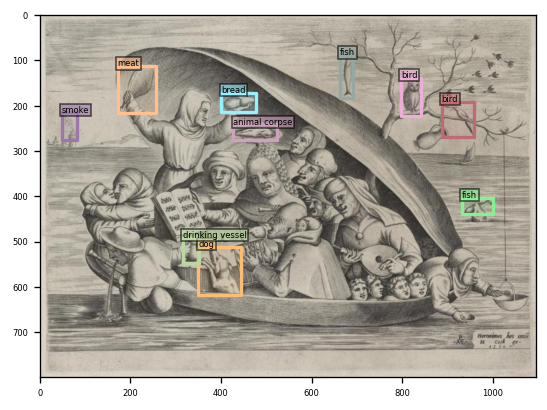

In [16]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [17]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

In [20]:
thershold = 0.2 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

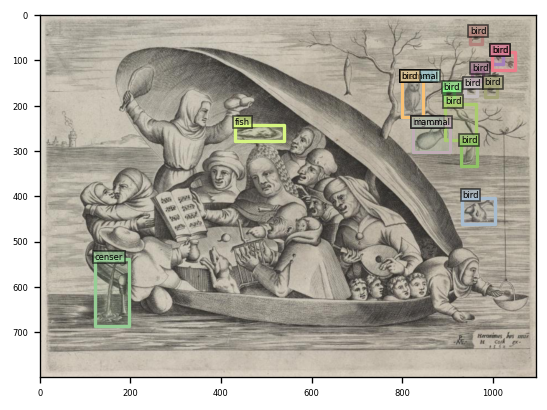

In [21]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# Generate predictions.json

In [22]:
# TODO: FIX, PREDICTS ONLY c. 20 cats

predictions = []
for i,img in enumerate(tqdm(dataset_val)):
    output = model.cuda()(image[None].cuda())
    output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]
    for score, label, box in zip(output['scores'], output['labels'], output['boxes']):
        ann_id = len(predictions)
        predictions.append({
            'id': ann_id,
            'category_id': label.item(),
            'image_id': i+1,
            'score': score.item(),
            'bbox': box.tolist()})

results_json = {
    'images': list(dataset_val.coco.imgs.values()),
    'annotations': predictions,
    'categories': list(dataset_val.coco.cats.values())
}
        
with open('predictions/ODOR_swin_50ep.json', 'w') as f:
    json.dump(results_json, f)

100%|██████████| 448/448 [01:57<00:00,  3.82it/s]


Error idx: 448


# 3. Visualize Custom Images

In [206]:
from PIL import Image
import datasets.transforms as T
import requests
from io import BytesIO

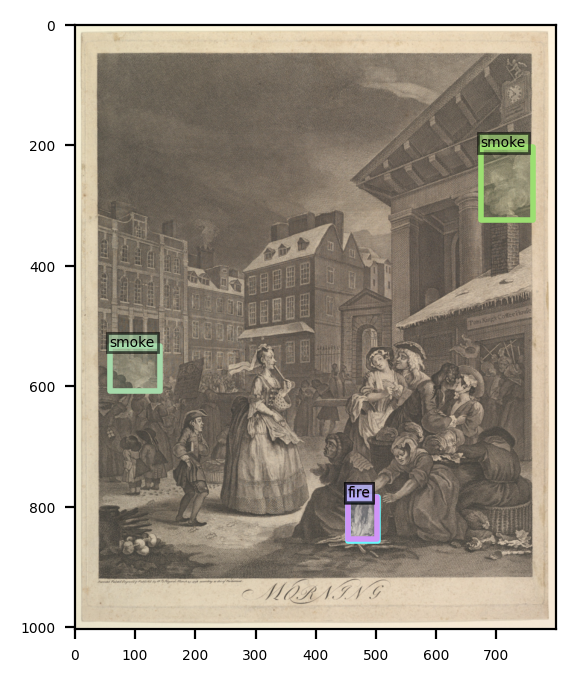

In [244]:
## from URL
# url = "https://uploads4.wikiart.org/images/george-hemming-mason/wind-on-the-wold-1863.jpg!Large.jpg"
# url = "https://uploads2.wikiart.org/images/pericles-pantazis/lighthouse-of-marseille.jpg"
url = "https://upload.wikimedia.org/wikipedia/commons/b/b8/Brueghel_II_-_An_Allegory_of_Smell.jpg"
url = "https://drive.google.com/file/d/1vN9gP1sWfSo-NCE9zaPOxeqOfNIvF9hQ/view?usp=sharing"
url = "https://images.metmuseum.org/CRDImages/dp/original/DP827065.jpg"

response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert("RGB")

# transform images
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

# visualize outputs
thershold = 0.3 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=200)

In [237]:
i = 0

2


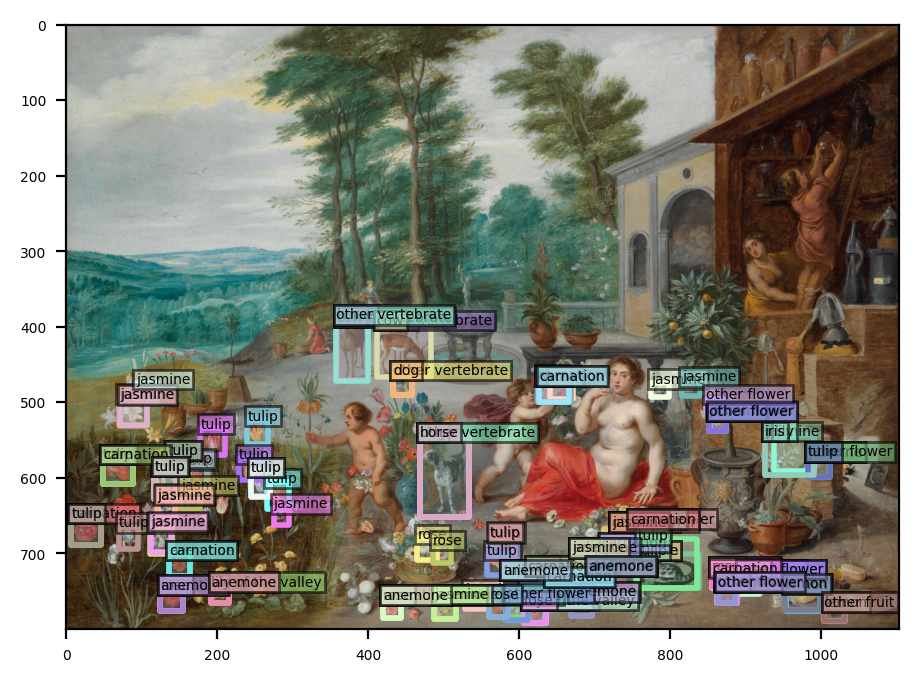

In [240]:
## from files
import glob
img_pths = glob.glob('./figs/art/*.jpg')
print(i)

image = Image.open(img_pths[0]).convert("RGB") # load image

# transform images
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

# visualize outputs
thershold = 0.15 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=200)

if i < len(img_pths):
    i+=1
else:
    i=0